<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonMachineLearning/blob/main/Online_Retail_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation - 고객 군집

* 조건
1. Online_Retail_작성자이름.ipynb
2. 탐색적데이터분석(EDA)
3. 군집분석
4. Metric -> 'silhouett Score' -> 권장 군집개수 제시




## 1.Import Packages and Google Drive Mount
### 1.Import Packages

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

### 2.Google Drive Mount


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.zip'

-rw------- 1 root root 22824989 Mar 11 00:24 '/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.zip'


## 2.Data PreProcessing
### 1.Unzip 'Online_Retail.zip'

In [4]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/Online_Retail.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.zip
  inflating: Online_Retail.xlsx      


In [5]:
!ls -l

total 23168
drwx------ 5 root root     4096 Mar 11 01:00 drive
-rw-r--r-- 1 root root 23715344 Mar  7 16:08 Online_Retail.xlsx
drwxr-xr-x 1 root root     4096 Mar  5 14:37 sample_data


### 2.Load Data

In [94]:
%%time

DF = pd.read_excel('Online_Retail.xlsx')

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
CPU times: user 41.4 s, sys: 420 ms, total: 41.8 s
Wall time: 41.9 s


### 3.데이터 설명
* InvoiceNo : 주문 번호, 'C' 시작은 주문취소
* StockCode : 제품 코드(Item Code)
* Description : 제품 설명
* Quanity : 주문 건수
* InvoiceDate : 주문 날짜
* UnitPrice : 제품 단가
* CustomerID : 고객 번호
* Country : 국가명(주문 고객 국적)


In [95]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 4.결측치 제거

In [96]:
DF = DF[DF['Quantity'] > 0]
DF = DF[DF['UnitPrice'] > 0]
DF = DF[DF['CustomerID'].notnull()]

DF.shape

(397884, 8)

In [9]:
DF.isnull().sum(axis = 0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 5.데이터 추출
'United Kingdom'만 사용 : 대부분의 구매자가 영국국적

In [97]:
DF['Country'].value_counts()[:10]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

In [98]:
DF = DF[DF['Country'] == 'United Kingdom']

DF.shape

(354321, 8)

In [99]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 6.Drop Columns 
Description과 Country는 더이상 필요하지 않을 것 같다.

In [100]:
DF = DF.drop(['Description', 'Country'], axis = 1)

DF.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0


### 7.필요변수 추가 및 변경
RFM기반 Data Reengineering(마케팅용어)
* RECENCY : 가장 최근 상품 구매일에서 오늘(마지막 구매일 다음날로 지정)까지 기간
* FREQUENCY : 상품 구매 횟수
* MONETARY VALUE : 총 구매 금액

RFM기반 Data Reengineering(마케팅용어)
* RECENCY : 가장 최근 상품 구매일에서 오늘(마지막 구매일 다음날로 지정)까지 기간
* FREQUENCY : 상품 구매 횟수
* MONETARY VALUE : 총 구매 금액


In [101]:
#sale_amount : 주문금액 = 주문개수 * 제품가격

DF['sale_amount'] = DF['Quantity'] * DF['UnitPrice']

DF.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,sale_amount
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [102]:
#CustomerID는 정수로 변환

DF['CustomerID'] = DF['CustomerID'].astype(int)

In [103]:
#주문건수 top5 회원
DF['CustomerID'].value_counts().head(5)

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

In [104]:
#주문금액 top5 회원
DF.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5]

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

In [106]:
#id기준으로 dataframe 재구성
aggregations = {'InvoiceDate' : 'max',
                'InvoiceNo' : 'count',
                'sale_amount' : 'sum'}

DF_CID = DF.groupby('CustomerID').agg(aggregations)

In [109]:
DF_CID = DF_CID.rename(columns = {'InvoiceDate' : 'Recency',
                                  'InvoiceNo' : 'Frequency',
                                  'sale_amount' : 'Monetary'})

DF_CID = DF_CID.reset_index()
DF_CID.head()

,index,CustomerID,Recency,Frequency,Monetary
0,0,12346,2011-01-18 10:01:00,1,77183.60
1,1,12747,2011-12-07 14:34:00,103,4196.01
2,2,12748,2011-12-09 12:20:00,4595,33719.73
3,3,12749,2011-12-06 09:56:00,199,4090.88
4,4,12820,2011-12-06 15:12:00,59,942.34


In [111]:
DF_CID['Recency'] = dt.datetime(2011, 12, 10) - DF_CID['Recency']
DF_CID['Recency'] = DF_CID['Recency'].apply(lambda x : x.days + 1)

DF_CID.head()

,index,CustomerID,Recency,Frequency,Monetary
0,0,12346,326,1,77183.60
1,1,12747,3,103,4196.01
2,2,12748,1,4595,33719.73
3,3,12749,4,199,4090.88
4,4,12820,4,59,942.34


## 3.EDA


In [112]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Quantity     354321 non-null  int64         
 3   InvoiceDate  354321 non-null  datetime64[ns]
 4   UnitPrice    354321 non-null  float64       
 5   CustomerID   354321 non-null  int64         
 6   sale_amount  354321 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 21.6+ MB


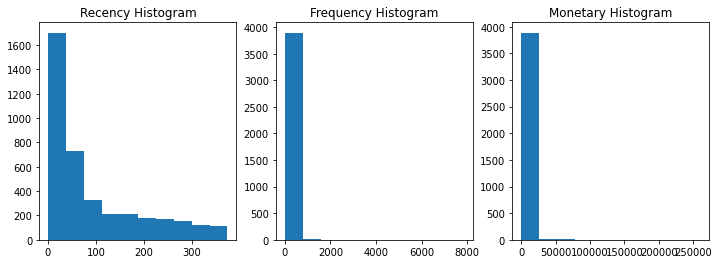

In [114]:
#변수 별 분포 확인
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12,4), nrows = 1, ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(DF_CID['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF_CID['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF_CID['Monetary'])

plt.show()

## 4.K-means Clustering
### 1. Standardization
* 표준화를 통한 평균과 표준편차 Scaling

In [115]:
DF_CID[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


* Scaling

In [118]:
X_input = DF_CID[['Recency','Frequency','Monetary']].values
X_input_scaled = StandardScaler().fit_transform(X_input)

In [121]:
X_input_scaled

array([[ 2.34381090e+00, -4.10449826e-01,  1.00669064e+01],
       [-9.01742172e-01,  5.79114471e-02,  3.11636875e-01],
       [-9.21838476e-01,  2.06841746e+01,  4.25767546e+00],
       ...,
       [-8.51501413e-01, -3.59940277e-01, -2.25389800e-01],
       [-8.91694020e-01,  3.05634195e+00,  3.08070865e-02],
       [-4.99816095e-01, -9.36172002e-02, -3.62284108e-03]])

### 2.Modeling
* k-means Clustering

In [122]:
#n_clusters의 갯수 판단 : Scree plot

inertia = []

K = range(1,10)

for k in K:
  kmeanModel = KMeans(n_clusters = k)
  kmeanModel.fit(DF_CID)
  inertia.append(kmeanModel.inertia_)

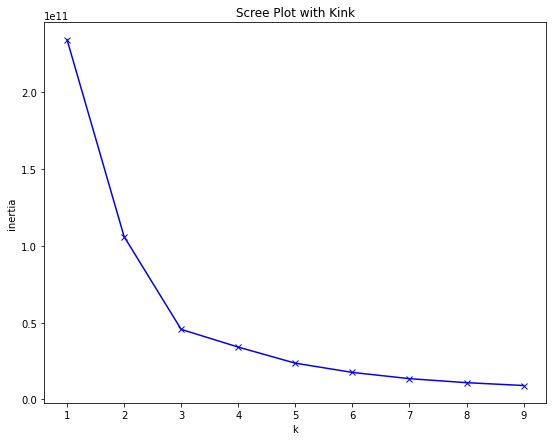

In [123]:
#결과상 그래프가 많이 완만해지는 지점은 4~6지점이다.
plt.figure(figsize = (9,7))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Scree Plot with Kink')
plt.show()

In [130]:
kmeans = KMeans(n_clusters=5,
                random_state = 2045)

kmeans.fit_predict(X_input_scaled)

array([1, 0, 4, ..., 0, 0, 0], dtype=int32)

### 3.Silhouette Score

In [131]:
#1에 가까워질 수록 좋다. n_clusters가 5에서 가장 높은 수치를 보인다.
silhouette_score(X_input_scaled, kmeans.fit_predict(X_input_scaled))

0.6114742734112578

2021/03/11 코드 추가하여 정리 완료